In [12]:
import numpy as np
import matplotlib.pyplot as plt

Generating a **dataset**.

In [13]:
rand = np.random.RandomState(124)
X = np.concatenate((rand.normal(3, 2, (250, 2)), rand.normal(15, 2, (250, 2)) - [12, 0]))
y = np.concatenate((np.ones(len(X)//2), np.zeros(len(X)//2)))

X.shape, y.shape

((500, 2), (500,))

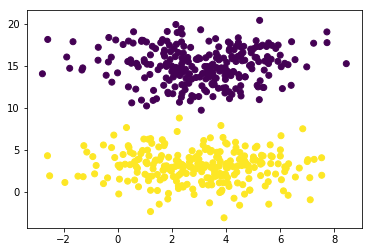

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y);

In [15]:
from sklearn.model_selection import train_test_split

X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
class EntropyFunc:
    
    @staticmethod
    def cross_entropy(x, y):
        # SUM p(x) * log2(x)
        classes, counts = np.unique(y, return_counts=True)
        p = counts / len(x)
        l_p = np.array([np.log(x) if not x is 0 else 0.0 for x in p])
        return - np.sum(p * (l_p / np.log(2)))
    
    @staticmethod
    def gini(x):
        return

In [20]:
from dataclasses import dataclass

@dataclass(init=True, repr=True)
class DecisionNode:
    
    X: np.ndarray
    y: np.ndarray
    split_value: float = None
    index: int = None
    left_node = None
    right_node = None
    is_leaf: bool = False

In [21]:
class DecisionTree:
    
    def __init__(self, entropy, sepr=50):
        self.entropy = entropy
        self.sepr = sepr
    
    def train(self, X, y, max_depth, leaf_count):
        self.leaf_count = leaf_count
        self.max_depth = max_depth
        self.h = []
        self.tree = self.add_node(DecisionNode(X, y, is_leaf=False))
        
        return self
    
    def add_node(self, node):
        
        self.max_depth -= 1
        
        split_value, index = self.__find_best_split(node.X, node.y)
        split_mask = (node.X >= split_value)[:, index]
        
        node.split_value, node.index = split_value, index
        
        if self.max_depth <= 0 or self.leaf_count <= 0:
            self.leaf_count -= 1
            node.is_leaf = True
            return node
        
        node.left_node = self.add_node(
            DecisionNode(node.X[~split_mask], node.y[~split_mask], 
                        is_leaf=False))
        node.right_node = self.add_node(
            DecisionNode(node.X[split_mask], node.y[split_mask], 
                        is_leaf=False))
        
        return node
    
    def __find_best_split(self, X, y):
        
        best_h = float('inf')
        best_split = None
        best_index = None
        
        for i in range(len(X.T)):
            for split in np.linspace(X.T[i].min(), X.T[i].max(), self.sepr)[1:-1]:
                mask = (X >= split)[:, i]
                h1 = self.entropy(X[mask], y[mask])
                h2 = self.entropy(X[~mask], y[~mask])
                if h1 + h2 < best_h:
                    best_h, best_split, best_index = h1 + h2, split, i

        self.h.append(best_h)
        return best_split, best_index
    
    def score(self, y_train, y_test):
        return np.sum(self.predict(y_train) == y_test) / len(y_train)
    
    def predict(self, y_train):
        return np.array([self.__predict_with_node(x, self.tree) for x in y_train])
        
    def __predict_with_node(self, x, node):
        if node.is_leaf:
            classes, counts = np.unique(node.y, return_counts=True)
            return classes[np.argmax(counts)]
        
        pred_f = self.__predict_with_node
        return (pred_f(x, node.right_node) 
                if x[node.index] >= node.split_value
               else pred_f(x, node.left_node))

In [22]:
decision_tree = DecisionTree(EntropyFunc.cross_entropy)
decision_tree.train(X_train, X_test, 2, 2)

In [23]:
decision_tree.score(y_train, y_test)

1.0

Test on **IRIS**.

In [24]:
from sklearn.datasets import load_iris

iris = load_iris()

X_train, y_train, X_test, y_test = train_test_split(iris.data, iris.target, 
                                                    test_size=0.4, 
                                                    random_state=123)

In [57]:
# is not used
def grid_search(params, entropy, X, y, folds=5):
    fold_size = len(X) // folds
    
    for fold in range(folds):
        mask = np.ones(len(X), dtype=bool)
        mask[fold * fold_size : ((fold + 1) * fold_size)] = False
        
        x_train, train_y = X[mask], X[~mask] 
        x_test, test_y = y[mask], y[~mask]
        
        models = [
            DecisionTree(entropy).train(x_train, x_test, **param)
            for param in params
        ]
        
        models_and_scores = [
            (model, model.score(train_y, test_y)) 
            for model in models
        ]
        
    models_and_scores.sort(key=lambda x:x[1], reverse=True)
    return models_and_scores[0]

In [58]:
decisionTree = DecisionTree(EntropyFunc.cross_entropy).train(X_train, X_test, 2, 3)

In [59]:
decisionTree.score(y_train, y_test)

0.6333333333333333